In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import imageio
from skimage import transform,io
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-learning-to-count/train.txt
/kaggle/input/mlub-learning-to-count/test/test/test_composite000000426.png
/kaggle/input/mlub-learning-to-count/train/train/train_composite000012068.png


In [54]:
df_train = pd.read_csv('/kaggle/input/mlub-learning-to-count/train.txt',sep=' ',header=None)
print(df_train.shape)
# take only the first 200 images
#df_train = df_train.head(500)

(15000, 2)


In [55]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import random
def data_augmentation(img, label, n_generated):
    datagen = ImageDataGenerator(rotation_range=45)
    data_augmentation = []
    data = img_to_array(img)
    samples = expand_dims(data, 0)
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(n_generated):
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('float64')
        image = image[:,:,0]
        data_augmentation.append((image, label))

    random.shuffle(data_augmentation)
    listX = [x[0] for x in data_augmentation]
    listy = [x[1] for x in data_augmentation]
    return listX, listy

In [56]:
data_dir = '/kaggle/input/mlub-learning-to-count/train/'
im_size = 64
X_aug = []
y_aug = []
for ind, item in df_train.iterrows():
    im  = imageio.imread(data_dir + item[0])/255.
    listx, listy = data_augmentation(im, item[1], 4)
    for im in range(len(listx)):
        small_im = transform.resize(listx[im], (im_size,im_size), mode='symmetric', preserve_range=True)
        X_aug.append(small_im)
        y_aug.append(listy[im])
    
    
    

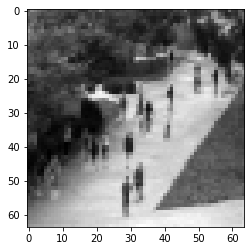

In [57]:
# read images and store into a np array

im_size = 64
N = df_train.shape[0]
X = np.zeros((N, im_size,im_size))
y = np.zeros((N))
cont =0

for ind, item in df_train.iterrows():
    im       = imageio.imread(data_dir + item[0])/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X[cont, :,:] = small_im
    y[cont] = item[1]
    cont+=1

plt.imshow(small_im,cmap='gray')
plt.show()

In [58]:
X = np.concatenate((X, X_aug))
y = np.concatenate((y, y_aug))

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.3, random_state=66)

In [60]:
from sklearn.ensemble import RandomForestRegressor
# random forest model 
'''rfc = RandomForestRegressor()
rfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)
# predictions
rfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))
'''

'rfc = RandomForestRegressor()\nrfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)\n# predictions\nrfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))\n'

In [61]:
from sklearn.metrics import mean_squared_error
'''plt.plot(rfc_predict,y_val,'.')

print(np.sqrt(mean_squared_error(rfc_predict,y_val)))'''

"plt.plot(rfc_predict,y_val,'.')\n\nprint(np.sqrt(mean_squared_error(rfc_predict,y_val)))"

In [62]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
history = {}

In [63]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [64]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

# create the model
model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=3, input_shape=[64, 64, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=30, activation='softmax')
])


In [65]:
model.layers

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [67]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [68]:
history = model.fit(X_train, y_train, epochs=500,
                    validation_data=(X_val, y_val),verbose=1)

Epoch 1/500
55/55 [==============================] - 1s 11ms/step - loss: 3.7401 - accuracy: 0.0383 - val_loss: 3.6051 - val_accuracy: 0.0533
Epoch 2/500
55/55 [==============================] - 0s 7ms/step - loss: 3.5317 - accuracy: 0.0474 - val_loss: 3.4933 - val_accuracy: 0.0533
Epoch 3/500
55/55 [==============================] - 0s 7ms/step - loss: 3.4091 - accuracy: 0.0486 - val_loss: 3.4212 - val_accuracy: 0.0560
Epoch 4/500
55/55 [==============================] - 0s 7ms/step - loss: 3.2362 - accuracy: 0.0760 - val_loss: 3.3158 - val_accuracy: 0.0947
Epoch 5/500
55/55 [==============================] - 0s 7ms/step - loss: 3.0307 - accuracy: 0.0977 - val_loss: 3.2700 - val_accuracy: 0.0800
Epoch 6/500
55/55 [==============================] - 0s 7ms/step - loss: 2.8553 - accuracy: 0.1297 - val_loss: 3.2404 - val_accuracy: 0.0720
Epoch 7/500
55/55 [==============================] - 0s 7ms/step - loss: 2.7375 - accuracy: 0.1326 - val_loss: 3.2027 - val_accuracy: 0.0653
Epoch 8/500


Epoch 59/500
55/55 [==============================] - 0s 7ms/step - loss: 1.4684 - accuracy: 0.5114 - val_loss: 1.8905 - val_accuracy: 0.4187
Epoch 60/500
55/55 [==============================] - 0s 7ms/step - loss: 1.4847 - accuracy: 0.5200 - val_loss: 1.9582 - val_accuracy: 0.3960
Epoch 61/500
55/55 [==============================] - 0s 7ms/step - loss: 1.3626 - accuracy: 0.5383 - val_loss: 2.4253 - val_accuracy: 0.3387
Epoch 62/500
55/55 [==============================] - 0s 7ms/step - loss: 1.4132 - accuracy: 0.5309 - val_loss: 2.4487 - val_accuracy: 0.3173
Epoch 63/500
55/55 [==============================] - 0s 7ms/step - loss: 1.4678 - accuracy: 0.5120 - val_loss: 1.8214 - val_accuracy: 0.4427
Epoch 64/500
55/55 [==============================] - 0s 7ms/step - loss: 1.4028 - accuracy: 0.5274 - val_loss: 1.8171 - val_accuracy: 0.4507
Epoch 65/500
55/55 [==============================] - 0s 7ms/step - loss: 1.4242 - accuracy: 0.5331 - val_loss: 1.7771 - val_accuracy: 0.4280
Epoch 

55/55 [==============================] - 0s 7ms/step - loss: 1.1040 - accuracy: 0.6463 - val_loss: 2.2371 - val_accuracy: 0.3787
Epoch 117/500
55/55 [==============================] - 0s 7ms/step - loss: 1.0361 - accuracy: 0.6646 - val_loss: 1.8873 - val_accuracy: 0.4813
Epoch 118/500
55/55 [==============================] - 0s 7ms/step - loss: 1.0692 - accuracy: 0.6537 - val_loss: 3.3882 - val_accuracy: 0.2067
Epoch 119/500
55/55 [==============================] - 0s 7ms/step - loss: 1.0100 - accuracy: 0.6834 - val_loss: 2.0689 - val_accuracy: 0.4493
Epoch 120/500
55/55 [==============================] - 0s 7ms/step - loss: 1.0554 - accuracy: 0.6566 - val_loss: 1.9187 - val_accuracy: 0.4907
Epoch 121/500
55/55 [==============================] - 0s 7ms/step - loss: 1.0556 - accuracy: 0.6697 - val_loss: 2.1249 - val_accuracy: 0.4520
Epoch 122/500
55/55 [==============================] - 0s 7ms/step - loss: 0.9749 - accuracy: 0.6811 - val_loss: 1.9419 - val_accuracy: 0.4827
Epoch 123/500

55/55 [==============================] - 0s 7ms/step - loss: 0.8660 - accuracy: 0.7429 - val_loss: 1.9705 - val_accuracy: 0.4987
Epoch 174/500
55/55 [==============================] - 0s 7ms/step - loss: 0.8221 - accuracy: 0.7543 - val_loss: 1.9154 - val_accuracy: 0.5187
Epoch 175/500
55/55 [==============================] - 0s 7ms/step - loss: 0.8315 - accuracy: 0.7491 - val_loss: 2.1191 - val_accuracy: 0.4587
Epoch 176/500
55/55 [==============================] - 0s 7ms/step - loss: 0.8208 - accuracy: 0.7434 - val_loss: 2.0119 - val_accuracy: 0.4880
Epoch 177/500
55/55 [==============================] - 0s 7ms/step - loss: 0.8200 - accuracy: 0.7434 - val_loss: 1.9732 - val_accuracy: 0.5147
Epoch 178/500
55/55 [==============================] - 0s 7ms/step - loss: 0.8486 - accuracy: 0.7423 - val_loss: 2.5398 - val_accuracy: 0.4467
Epoch 179/500
55/55 [==============================] - 0s 7ms/step - loss: 0.8079 - accuracy: 0.7423 - val_loss: 1.8960 - val_accuracy: 0.5093
Epoch 180/500

55/55 [==============================] - 0s 7ms/step - loss: 0.7195 - accuracy: 0.7731 - val_loss: 1.9443 - val_accuracy: 0.5280
Epoch 231/500
55/55 [==============================] - 0s 7ms/step - loss: 0.7472 - accuracy: 0.7777 - val_loss: 1.9565 - val_accuracy: 0.4973
Epoch 232/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6844 - accuracy: 0.8000 - val_loss: 2.5790 - val_accuracy: 0.4173
Epoch 233/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6759 - accuracy: 0.7943 - val_loss: 2.0833 - val_accuracy: 0.4653
Epoch 234/500
55/55 [==============================] - 0s 7ms/step - loss: 0.7397 - accuracy: 0.7806 - val_loss: 1.9582 - val_accuracy: 0.5133
Epoch 235/500
55/55 [==============================] - 0s 7ms/step - loss: 0.7292 - accuracy: 0.7811 - val_loss: 2.0096 - val_accuracy: 0.5080
Epoch 236/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6971 - accuracy: 0.8017 - val_loss: 2.5441 - val_accuracy: 0.4653
Epoch 237/500

55/55 [==============================] - 0s 7ms/step - loss: 0.6657 - accuracy: 0.8000 - val_loss: 2.2066 - val_accuracy: 0.5333
Epoch 288/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5887 - accuracy: 0.8229 - val_loss: 2.1915 - val_accuracy: 0.4867
Epoch 289/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6304 - accuracy: 0.8017 - val_loss: 2.0356 - val_accuracy: 0.5160
Epoch 290/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6455 - accuracy: 0.8069 - val_loss: 3.6689 - val_accuracy: 0.2640
Epoch 291/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6891 - accuracy: 0.7897 - val_loss: 1.9713 - val_accuracy: 0.5360
Epoch 292/500
55/55 [==============================] - 0s 8ms/step - loss: 0.6419 - accuracy: 0.8120 - val_loss: 2.3621 - val_accuracy: 0.4573
Epoch 293/500
55/55 [==============================] - 0s 9ms/step - loss: 0.6301 - accuracy: 0.8143 - val_loss: 2.3559 - val_accuracy: 0.4667
Epoch 294/500

55/55 [==============================] - 0s 7ms/step - loss: 0.5983 - accuracy: 0.8303 - val_loss: 2.0902 - val_accuracy: 0.5387
Epoch 345/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6026 - accuracy: 0.8211 - val_loss: 3.6663 - val_accuracy: 0.3040
Epoch 346/500
55/55 [==============================] - 0s 7ms/step - loss: 0.6086 - accuracy: 0.8189 - val_loss: 2.8267 - val_accuracy: 0.4547
Epoch 347/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5922 - accuracy: 0.8280 - val_loss: 2.2271 - val_accuracy: 0.4947
Epoch 348/500
55/55 [==============================] - 1s 10ms/step - loss: 0.5812 - accuracy: 0.8457 - val_loss: 2.3202 - val_accuracy: 0.4640
Epoch 349/500
55/55 [==============================] - 0s 8ms/step - loss: 0.5414 - accuracy: 0.8440 - val_loss: 2.1162 - val_accuracy: 0.5427
Epoch 350/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5643 - accuracy: 0.8411 - val_loss: 2.4606 - val_accuracy: 0.5000
Epoch 351/50

55/55 [==============================] - 0s 7ms/step - loss: 0.5125 - accuracy: 0.8577 - val_loss: 2.2066 - val_accuracy: 0.5253
Epoch 402/500
55/55 [==============================] - 0s 9ms/step - loss: 0.5633 - accuracy: 0.8371 - val_loss: 2.1105 - val_accuracy: 0.5253
Epoch 403/500
55/55 [==============================] - 0s 8ms/step - loss: 0.5290 - accuracy: 0.8474 - val_loss: 2.1451 - val_accuracy: 0.5253
Epoch 404/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5164 - accuracy: 0.8429 - val_loss: 2.3355 - val_accuracy: 0.5200
Epoch 405/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5442 - accuracy: 0.8360 - val_loss: 2.6090 - val_accuracy: 0.4627
Epoch 406/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5259 - accuracy: 0.8543 - val_loss: 2.3260 - val_accuracy: 0.5427
Epoch 407/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5177 - accuracy: 0.8577 - val_loss: 2.1465 - val_accuracy: 0.5347
Epoch 408/500

55/55 [==============================] - 0s 7ms/step - loss: 0.4758 - accuracy: 0.8726 - val_loss: 2.3150 - val_accuracy: 0.5107
Epoch 459/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5140 - accuracy: 0.8589 - val_loss: 2.3660 - val_accuracy: 0.5040
Epoch 460/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5074 - accuracy: 0.8474 - val_loss: 2.4556 - val_accuracy: 0.5133
Epoch 461/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5456 - accuracy: 0.8469 - val_loss: 3.8137 - val_accuracy: 0.3200
Epoch 462/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5562 - accuracy: 0.8503 - val_loss: 2.1275 - val_accuracy: 0.5240
Epoch 463/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5178 - accuracy: 0.8497 - val_loss: 2.3252 - val_accuracy: 0.5293
Epoch 464/500
55/55 [==============================] - 0s 7ms/step - loss: 0.5048 - accuracy: 0.8577 - val_loss: 3.8263 - val_accuracy: 0.3200
Epoch 465/500

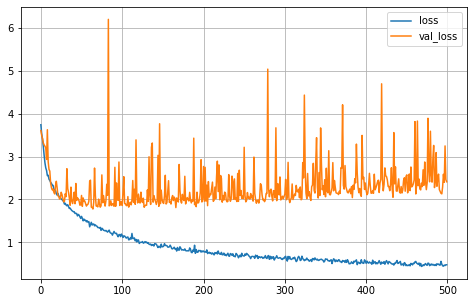

In [69]:
import pandas as pd

pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

[ 1. 17. 29. 12.  3.  3. 26.  5.  3. 21. 21. 18. 19. 19. 23.  6.  0. 10.
 10. 18.  7. 20.  7. 22. 18. 23.  5.  3.  3. 24.  3. 18. 10. 21. 29.  7.
  7.  0. 10. 17.  9. 21.  2. 20. 18. 21. 10. 26. 25. 27. 19. 18.  8. 22.
 17. 14.  7. 28. 10. 17.  4. 22. 28. 11.  1.  4. 10.  8.  0. 11. 19. 16.
 25. 25. 23.  6.  3.  9. 28. 29. 26. 15. 24. 29. 22.  0.  0. 13.  6. 15.
 22. 28.  7. 25. 28. 23.  8. 13.  3. 25.  8. 19.  0. 20. 21. 18.  6.  7.
  8.  1. 20.  5. 19. 19. 19. 10. 18.  6. 29. 25.  0.  6. 23. 23. 24.  0.
  7.  0.  5. 26.  5.  6. 10. 26. 13.  3. 21. 13. 26.  4.  3.  3.  7. 16.
 13.  1.  7. 15. 25. 27.  3. 12. 18. 12.  2. 11.  3. 17. 12. 16. 25. 28.
 21.  8. 25. 24.  3. 23. 11. 19. 18. 10.  9. 15.  7. 12.  7. 27. 28. 25.
 18. 14.  0. 18. 23. 15. 20. 22. 29. 29.  8. 10.  9.  2. 10. 26. 27.  5.
 17. 26. 24. 29. 25. 13. 21. 21. 23.  0. 19. 20.  1. 15. 26.  0.  0. 22.
 18. 18.  0. 23. 25. 26. 18. 16.  1. 12. 29. 28. 26. 20.  3. 22. 26. 10.
  0. 26. 29. 25.  0. 14. 28.  2. 25. 14. 27.  2. 23

3.1723808094237365

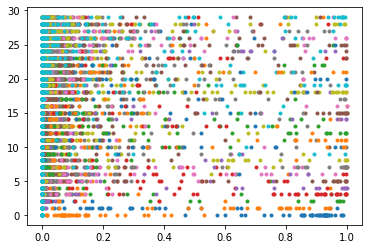

In [70]:
y_model1 = model.predict(X_val)
plt.plot(y_model1,y_val,'.')
print(y_val)
y_model_output = []
for i in y_model1:
    y_model_output.append(np.argmax(i))
print(y_model_output)
np.sqrt(mean_squared_error(y_model_output,y_val))

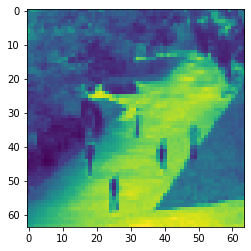

In [71]:
## evaluate test and generate submission
test_dir = '/kaggle/input/mlub-learning-to-count/test/test/'
im_size = 64
N = 500
X_test = np.zeros((N, im_size,im_size))
cont =0

for x in range(500):
    im       = imageio.imread(test_dir + 'test_composite'+str(x).zfill(9) + '.png')/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X_test[cont, :,:] = small_im
    cont+=1
    
plt.imshow(small_im)
plt.show()

In [72]:
X_test = X_test[..., np.newaxis]

In [73]:
# create the file to make the sumbission

y_test = model.predict(X_test)
print(y_test)
y_test = [np.argmax(x) for x in y_test]

df_output = pd.DataFrame(y_test)
df_output.index.name = 'index'
df_output.columns = ['prediction']
df_output.to_csv('output.csv')


[[2.2895845e-11 7.2689391e-13 3.2066690e-15 ... 8.5085973e-02
  8.4153140e-01 6.2926136e-02]
 [5.2680974e-07 1.3356554e-06 3.3845765e-06 ... 6.7037897e-04
  2.9636007e-03 1.6717395e-03]
 [9.7346087e-10 4.6088121e-07 1.5142911e-05 ... 4.7454191e-10
  3.5500602e-11 1.6092571e-09]
 ...
 [1.1939892e-03 3.3846635e-02 1.8643642e-02 ... 1.5237364e-19
  5.6618859e-19 3.8258903e-15]
 [2.0155559e-09 1.9134628e-08 1.1117002e-06 ... 5.7769619e-04
  4.2343713e-04 3.2628229e-04]
 [4.2295856e-08 3.7092859e-06 2.9390338e-03 ... 3.2469685e-17
  1.0478819e-17 5.0938968e-13]]


In [74]:
print(y_test)

[28, 20, 10, 19, 18, 7, 25, 17, 1, 8, 25, 3, 3, 17, 21, 3, 7, 4, 26, 18, 3, 20, 25, 7, 11, 0, 3, 3, 5, 1, 12, 22, 11, 15, 29, 0, 13, 7, 4, 3, 13, 13, 6, 25, 17, 11, 15, 25, 3, 17, 25, 4, 25, 7, 1, 27, 3, 17, 15, 19, 25, 13, 15, 1, 3, 12, 0, 6, 11, 11, 18, 1, 0, 12, 20, 6, 5, 21, 10, 20, 3, 13, 25, 17, 3, 16, 15, 28, 19, 15, 21, 28, 27, 3, 29, 24, 12, 12, 1, 3, 11, 12, 19, 19, 18, 7, 13, 20, 13, 7, 22, 18, 20, 18, 29, 8, 11, 6, 5, 15, 26, 3, 4, 22, 10, 13, 6, 13, 3, 12, 20, 15, 4, 10, 14, 17, 3, 13, 10, 3, 13, 3, 14, 12, 0, 10, 21, 25, 17, 15, 3, 15, 19, 25, 7, 1, 18, 17, 25, 27, 0, 11, 17, 10, 13, 17, 8, 17, 23, 7, 12, 11, 18, 15, 8, 5, 25, 27, 1, 29, 1, 19, 4, 19, 3, 7, 17, 19, 27, 11, 19, 7, 24, 25, 19, 12, 12, 20, 8, 24, 29, 11, 25, 11, 19, 25, 17, 24, 18, 4, 17, 25, 10, 22, 25, 18, 2, 3, 13, 0, 13, 1, 25, 26, 25, 5, 26, 13, 5, 2, 25, 26, 5, 18, 15, 7, 24, 24, 6, 0, 7, 13, 3, 2, 12, 25, 3, 7, 16, 8, 3, 12, 13, 1, 8, 6, 26, 2, 26, 11, 19, 0, 21, 25, 3, 3, 0, 7, 10, 2, 7, 1, 12, 26, 1